In [1]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, GlobalAveragePooling2D, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


# --- Hàm load ảnh ---
def load_images_from_paths(paths, img_size=(64,64)):
    images = []
    labels = []
    valid_ext = ('.jpg','.jpeg','.png','.bmp','.gif')
    for idx, p in enumerate(paths):
        if not os.path.exists(p):
            print(f"Warning: path not found {p}")
            continue
        for f in os.listdir(p):
            if not f.lower().endswith(valid_ext):
                continue
            try:
                img = Image.open(os.path.join(p,f)).convert('RGB').resize(img_size)
                img = np.array(img).astype(np.float32)/255.0
                if img.shape != (img_size[0], img_size[1], 3):
                    continue
                images.append(img)
                labels.append(idx)
            except Exception as e:
                print(f"Failed loading {f}: {e}")
                continue
    return np.array(images), np.array(labels)

# --- Lớp ConvMultiHeadAttention ---
class ConvMultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, kernel_size=3, strides=1, padding="same", dropout=0.0):
        super().__init__()
        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.projection_dim = embed_dim // num_heads
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding
        self.dropout_rate = dropout

        # Convolutional projections for Q, K, V
        self.q_conv = Conv2D(embed_dim, kernel_size, strides, padding, use_bias=False)
        self.k_conv = Conv2D(embed_dim, kernel_size, strides, padding, use_bias=False)
        self.v_conv = Conv2D(embed_dim, kernel_size, strides, padding, use_bias=False)

        self.dropout = Dropout(dropout)
        self.layernorm = LayerNormalization(epsilon=1e-6)
        self.dense = Dense(embed_dim)

    def split_heads(self, x, batch_size):
        # x shape: (batch_size, seq_len, embed_dim)
        # reshape -> (batch_size, seq_len, num_heads, projection_dim)
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        # transpose -> (batch_size, num_heads, seq_len, projection_dim)
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs, training=False):
        batch_size = tf.shape(inputs)[0]

        q = self.q_conv(inputs)  # (B, H, W, embed_dim)
        k = self.k_conv(inputs)
        v = self.v_conv(inputs)

        # flatten spatial dims (H*W)
        q = tf.reshape(q, (batch_size, -1, self.embed_dim))
        k = tf.reshape(k, (batch_size, -1, self.embed_dim))
        v = tf.reshape(v, (batch_size, -1, self.embed_dim))

        # split heads
        q = self.split_heads(q, batch_size)  # (B, heads, seq_len, projection_dim)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        # scaled dot-product attention
        matmul_qk = tf.matmul(q, k, transpose_b=True)  # (B, heads, seq_len, seq_len)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        attention_weights = self.dropout(attention_weights, training=training)

        output = tf.matmul(attention_weights, v)  # (B, heads, seq_len, projection_dim)

        # concat heads
        output = tf.transpose(output, perm=[0, 2, 1, 3])  # (B, seq_len, heads, projection_dim)
        concat_attention = tf.reshape(output, (batch_size, -1, self.embed_dim))  # (B, seq_len, embed_dim)

        # final linear layer
        output = self.dense(concat_attention)  # (B, seq_len, embed_dim)

        # reshape back to spatial
        size = int(tf.math.sqrt(tf.cast(tf.shape(output)[1], tf.float32)))
        output = tf.reshape(output, (batch_size, size, size, self.embed_dim))

        return output

# --- Lớp ConvTransformerBlock ---


class ConvTransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1, **kwargs):
        super().__init__(**kwargs)  # Truyền kwargs lên lớp cha để hỗ trợ serialize
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.dropout_rate = dropout

        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.att = ConvMultiHeadAttention(embed_dim, num_heads, dropout=dropout)  
        self.dropout1 = Dropout(dropout)

        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.dropout2 = Dropout(dropout)

    def call(self, inputs, training=False):
        x_norm = self.layernorm1(inputs)
        attn_output = self.att(x_norm, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = inputs + attn_output

        out1_norm = self.layernorm2(out1)
        ffn_output = self.ffn(out1_norm)
        ffn_output = self.dropout2(ffn_output, training=training)
        return out1 + ffn_output

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "dropout": self.dropout_rate,
        })
        return config

# --- Patch Embedding CvT ---
def patch_embedding(inputs, embed_dim=64, patch_size=4):
    x = Conv2D(embed_dim, kernel_size=patch_size, strides=patch_size, padding="valid")(inputs)
    x = LayerNormalization(epsilon=1e-6)(x)
    return x

# --- Tạo model feature extractor ---
def create_cvt_feature_extractor(input_shape=(64,64,3)):
    inputs = Input(shape=input_shape)
    x = patch_embedding(inputs, embed_dim=64, patch_size=4)  # 64x64 -> 16x16 với 64 kênh

    # Stack ConvTransformer blocks, có thể tăng số block 
    x = ConvTransformerBlock(embed_dim=64, num_heads=4, ff_dim=128)(x)
    x = ConvTransformerBlock(embed_dim=64, num_heads=4, ff_dim=128)(x)
    # Có thể thêm block 

    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.3)(x)

    model = Model(inputs, x)
    return model

# --- Đường dẫn dữ liệu ---
root_dir = "/kaggle/input/cervical-cancer-largest-dataset-sipakmed/"
paths = [
    os.path.join(root_dir, "im_Dyskeratotic", "im_Dyskeratotic", "CROPPED"),
    os.path.join(root_dir, "im_Koilocytotic", "im_Koilocytotic", "CROPPED"),
    os.path.join(root_dir, "im_Metaplastic", "im_Metaplastic", "CROPPED"),
    os.path.join(root_dir, "im_Parabasal", "im_Parabasal", "CROPPED"),
    os.path.join(root_dir, "im_Superficial-Intermediate", "im_Superficial-Intermediate", "CROPPED")
]

# --- Load dữ liệu ---
X, y = load_images_from_paths(paths)
num_classes = len(paths)

# --- Chia dữ liệu ---
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42, stratify=y_tmp)

# --- Data augmentation ---
datagen = ImageDataGenerator(rotation_range=15,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True)
datagen.fit(X_train)

# --- Tạo model feature extractor ---
feature_extractor = create_cvt_feature_extractor(input_shape=(64, 64, 3))  # Khởi tạo feature extractor

# --- Tạo model feature extractor và thêm softmax ---
inputs = feature_extractor.input
features = feature_extractor.output
outputs = Dense(num_classes, activation="softmax")(features)

# --- Kết hợp feature extractor với layer phân loại ---
train_model = Model(inputs, outputs)

# --- Biên dịch model ---
train_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# --- Huấn luyện ---
history = train_model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=200,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=80, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, verbose=1),
        tf.keras.callbacks.ModelCheckpoint("best_cvt_model.h5", save_best_only=True, monitor="val_loss")
    ]
)

# --- Đánh giá ---
val_loss, val_acc = train_model.evaluate(X_val, y_val, batch_size=32)
test_loss, test_acc = train_model.evaluate(X_test, y_test, batch_size=32)

# --- Dự đoán nhãn cho tập test ---
y_pred = train_model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)  # Chọn nhãn có xác suất cao nhất

# --- Tính toán F1, Recall, Precision ---
print("Validation Accuracy:", val_acc)
print("Test Accuracy:", test_acc)
print("Classification Report:")
print(classification_report(y_test, y_pred_labels, target_names=[f"Class {i}" for i in range(num_classes)]))


Epoch 1/200
89/89 [==============================] - 15s 47ms/step - loss: 1.4505 - accuracy: 0.4079 - val_loss: 1.1466 - val_accuracy: 0.5025
Epoch 2/200
89/89 [==============================] - 4s 40ms/step - loss: 1.1221 - accuracy: 0.5448 - val_loss: 1.0747 - val_accuracy: 0.5470
Epoch 3/200
89/89 [==============================] - 4s 40ms/step - loss: 0.9102 - accuracy: 0.6538 - val_loss: 0.8465 - val_accuracy: 0.6903
Epoch 4/200
89/89 [==============================] - 4s 40ms/step - loss: 0.7747 - accuracy: 0.7163 - val_loss: 0.9003 - val_accuracy: 0.6557
Epoch 5/200
89/89 [==============================] - 4s 39ms/step - loss: 0.6385 - accuracy: 0.7664 - val_loss: 0.4270 - val_accuracy: 0.8418
Epoch 6/200
89/89 [==============================] - 4s 40ms/step - loss: 0.5564 - accuracy: 0.7957 - val_loss: 0.4977 - val_accuracy: 0.8040
Epoch 7/200
89/89 [==============================] - 4s 40ms/step - loss: 0.5207 - accuracy: 0.8013 - val_loss: 0.4605 - val_accuracy: 0.8155
Epoch

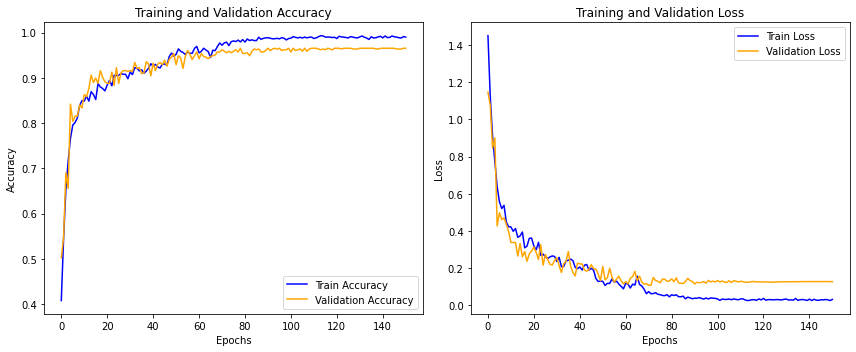

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# --- Visualize Training History ---
plt.figure(figsize=(12, 5))

# Biểu đồ Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

# Biểu đồ Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()



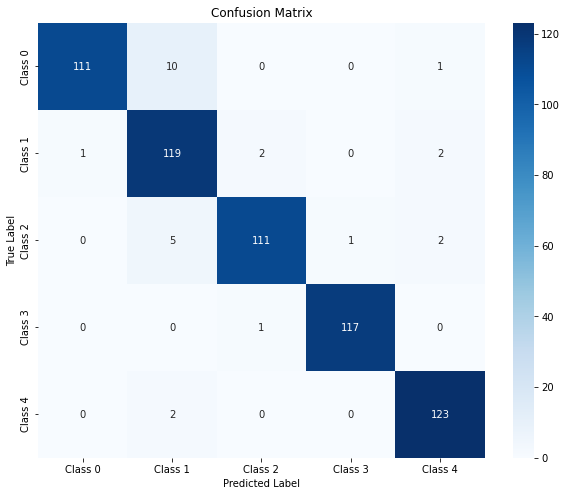

In [3]:

# --- Ma trận nhầm lẫn ---
cm = confusion_matrix(y_test, y_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f"Class {i}" for i in range(num_classes)],
            yticklabels=[f"Class {i}" for i in range(num_classes)])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

10 test predictions vs actual labels:
Prediction: 3, Actual: 3
Prediction: 1, Actual: 1
Prediction: 0, Actual: 0
Prediction: 3, Actual: 3
Prediction: 3, Actual: 3
Prediction: 2, Actual: 2
Prediction: 0, Actual: 0
Prediction: 4, Actual: 4
Prediction: 4, Actual: 4
Prediction: 0, Actual: 0


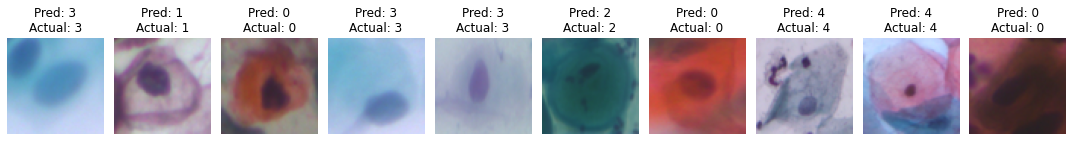

In [4]:
# --- In ra 10 giá trị dự đoán và thực tế từ tập test ---
print("10 test predictions vs actual labels:")
for i in range(10):
    print(f"Prediction: {y_pred_labels[i]}, Actual: {y_test[i]}")

# --- Hiển thị ảnh cùng dự đoán và nhãn thực tế ---
def display_images_with_predictions(X_test, y_pred_labels, y_test, num_images=10):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(X_test[i])
        plt.title(f"Pred: {y_pred_labels[i]}\nActual: {y_test[i]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

display_images_with_predictions(X_test, y_pred_labels, y_test, num_images=10)

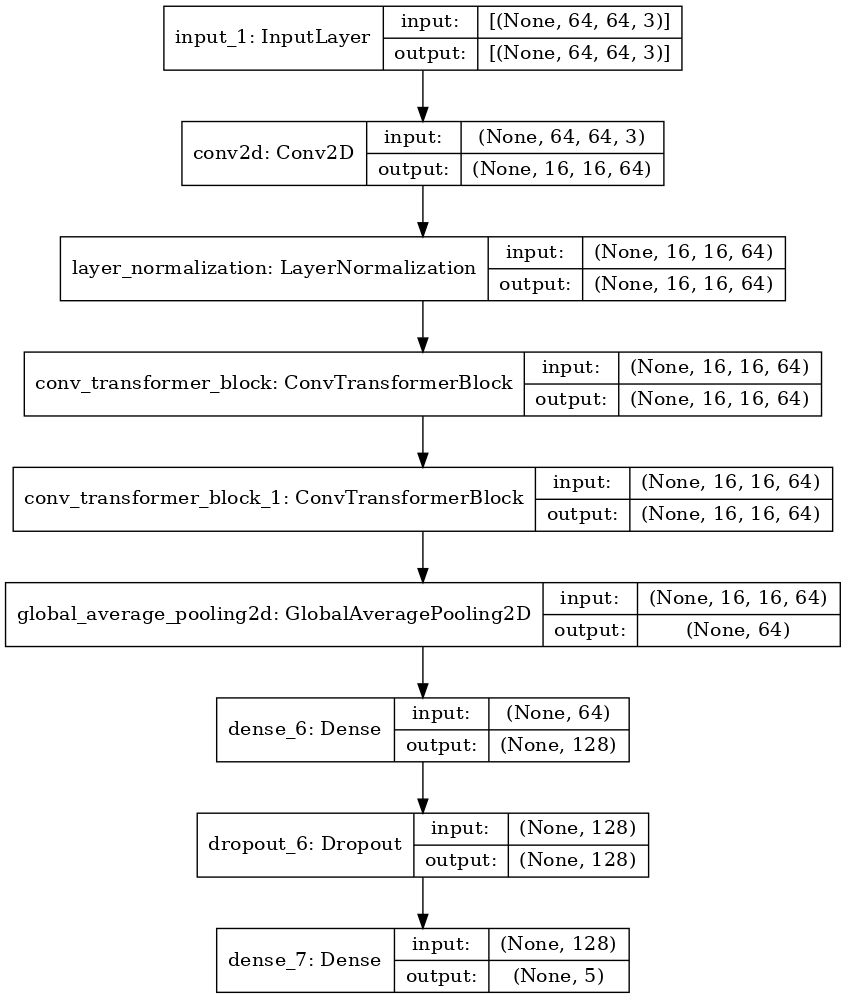

In [5]:
from tensorflow.keras.utils import plot_model
plot_model(train_model, to_file='model.png', show_shapes=True, show_layer_names=True, expand_nested=True, dpi=100)